This notebook is used to import the data and pre-process it.

# Importation

In [20]:
from gutenberg.acquire import load_etext
from gutenberg.cleanup import strip_headers
from gutenberg.query import get_metadata
from tqdm import tqdm
import pandas as pd
import numpy as np
import json 
import pickle
import string

import matplotlib.pyplot as plt
from Book import Book
from sklearn.preprocessing import MultiLabelBinarizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Datasets

## Gutenberg module (too long to load, not used)

### Test

In [9]:
#A simple test to see if the module Gutenberg is well installed 
try:
    load_etext(1)
except:
    print("WARNING Review your installation of the Gutenberg module, you might need to change the mirror used. See README.")

### Loading all books

In [12]:
books={}
for i in tqdm(range(10)):
    try:
        book=strip_headers(load_etext(i)).strip()
        #author,=get_metadata('author', i)
        #title, =get_metadata('title', i)
        #genres=get_metadata('subject', i)
    except:
        continue
    books[i]={}
    books[i]['text']=book
    #books[i]['title']=title
    #books[i]['author']=author
   # books[i]['genres']=genres  #TODO clean this list

100%|██████████| 10/10 [00:00<00:00, 112.69it/s]


In [13]:
print(f'{len(books)} books were downloaded')

9 books were downloaded


## 10 000 e-books

In [14]:
data_path='./data/books_and_genres.csv'
raw_data = pd.read_csv(data_path)

In [15]:
books_df=raw_data.dropna().reset_index(drop=True)
books_df = books_df.iloc[: , 1:]

In [16]:
books_df.head()

,title,text,genres
0,apocolocyntosis,"Produced by Ted Garvin, Ben Courtney and PG Di...","{'21st-century', 'history', 'roman', 'classics..."
1,the house on the borderland,"Produced by Suzanne Shell, Sjaani and PG Distr...","{'horror', 'mystery', 'classics', 'science-fic..."
2,the warriors,"Produced by Charles Aldarondo, Charlie Kirschn...","{'literary-fiction', 'history', 'biography', '..."
3,a voyage to the moon,"Produced by Christine De Ryck, Stig M. Valstad...","{'20th-century', 'science-fiction', 'speculati..."
4,la fiammetta,"Produced by Ted Garvin, Dave Morgan and PG Dis...","{'literary-fiction', 'history', 'feminism', 'c..."


In [17]:
genres_dict = {}
genres_count={}
new_genres=[]
i=0
for genres_str in books_df.genres:
    genres_list = genres_str[1:len(genres_str)-1].split(', ')
    for genre in genres_list:
        if genre not in genres_dict:
            genres_dict[genre]=i
            genres_count[genre]=1
            i+=1
        else:
            genres_count[genre]+=1
    new_genres.append([genres_dict[g] for g in genres_list])

In [18]:
books_df['idx_genres']=pd.Series(new_genres)

## Books to chapters

In [27]:
books_df

,title,text,genres,idx_genres
0,apocolocyntosis,"Produced by Ted Garvin, Ben Courtney and PG Di...","{'21st-century', 'history', 'roman', 'classics...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,the house on the borderland,"Produced by Suzanne Shell, Sjaani and PG Distr...","{'horror', 'mystery', 'classics', 'science-fic...","[16, 17, 3, 18, 19, 5, 8, 7, 20, 21, 22, 23, 2..."
2,the warriors,"Produced by Charles Aldarondo, Charlie Kirschn...","{'literary-fiction', 'history', 'biography', '...","[26, 1, 27, 28, 29, 30, 11, 14, 31, 32, 33, 19..."
3,a voyage to the moon,"Produced by Christine De Ryck, Stig M. Valstad...","{'20th-century', 'science-fiction', 'speculati...","[21, 18, 23]"
4,la fiammetta,"Produced by Ted Garvin, Dave Morgan and PG Dis...","{'literary-fiction', 'history', 'feminism', 'c...","[26, 1, 37, 3, 6, 7, 8, 21, 35, 11, 12, 13, 31]"
...,...,...,...,...
10368,young folks history,"This E-text was created by Doug Levy, _litter...","{'fiction', '20th-century', 'history'}","[7, 21, 1]"
10369,yollop,"Produced by Charles Aldarondo, Charles Franks\...","{'classics', 'american', 'humor'}","[3, 36, 15]"
10370,sketches of young couples,Transcribed from the 1903 edition by David Pri...,"{'romance', 'history', 'classics', 'fiction', ...","[41, 1, 3, 7, 9, 21, 30, 11, 15]"
10371,the yosemite,Produced by Dan Anderson and Andrew Sly.\nThan...,"{'adventure', 'history', 'biography', 'classic...","[50, 1, 27, 3, 51, 89, 7, 8, 21, 52, 39, 34, 1..."


In [46]:
row=books_df.loc[4,:]
try:
    b=Book(row['text'])
    chap=b.rebuild_chapters()
    heading=b.contents[b.headings[0]:b.headings[1]].split('\n\n\n\n')
    auth=heading[1]
except:
    chap=[row['text']]
    auth=None

In [47]:
chap_df=pd.DataFrame({'chap_text':chap})
chap_df['title']=row['title']
chap_df['genres']=row['genres']
chap_df['author']=auth

In [32]:
all_chapters=[]
for i, row in books_df.iterrows():
    try:
        b=Book(row['text'])
        chap=b.rebuild_chapters()
        heading=b.contents[b.headings[0]:b.headings[1]].split('\n\n\n\n')
        auth=heading[1]
    except:
        chap=row['text']
    chap_df=pd.DataFrame(chap)

In [ ]:
len(all_chapters)

207489

In [ ]:
books_df.loc[3, 'text']

'Produced by Christine De Ryck, Stig M. Valstad, Suzanne L. Shell\nand PG Distributed Proofreaders\n\n\n\n\n                      A\n             VOYAGE TO THE MOON:\n                     WITH\n                 SOME ACCOUNT\n                    OF THE\n  MANNERS AND CUSTOMS, SCIENCE AND PHILOSOPHY,\n                    OF THE\n              PEOPLE OF MOROSOFIA,\n                     AND\n                OTHER LUNARIANS.\n\n\n\n        BY GEORGE TUCKER (JOSEPH ATTERLEY)\n\n\n\n\n    "It is the very error of the moon,\n    She comes more near the earth than she was wont,\n    And makes men mad."--_Othello_.\n\n\n\n                    1827\n\n\n     CONTENTS.\n\n\n\n     CHAPTER I.\n\nAtterley\'s birth and education--He makes a voyage--\n  Founders off the Burman coast--Adventures in\n  that Empire--Meets with a learned Brahmin from\n  Benares.\n\n     CHAPTER II.\n\nThe Brahmin\'s illness--He reveals an important secret\n  to Atterley--Curious information concerning the\n  Moon--The Glon

In [ ]:
b.contents[b.headings[0]:b.headings[1]].split('\n\n\n\n')

['     PEOPLE OF MOROSOFIA,\n                     AND\n                OTHER LUNARIANS.',
 '        BY GEORGE TUCKER (JOSEPH ATTERLEY)',
 '\n    "It is the very error of the moon,\n    She comes more near the earth than she was wont,\n    And makes men mad."--_Othello_.',
 '                    1827\n\n\n     CONTENTS.',
 '     C']

In [ ]:
b.getStats()

AttributeError: 'Book' object has no attribute 'filename'

In [ ]:
#Average length of book
np.mean(books_df.text.str.len())

345224.3857129085

In [ ]:
dict(sorted(genres_count.items(), key=lambda item: item[1], reverse=True))

{"'fiction'": 7125,
 "'classics'": 5351,
 "'20th-century'": 3159,
 "'non-fiction'": 2951,
 "'literature'": 2866,
 "'history'": 2838,
 "'historical-fiction'": 2592,
 "'novels'": 2332,
 "'historical'": 2219,
 "'romance'": 2107,
 "'short-stories'": 1921,
 "'fantasy'": 1347,
 "'literary-fiction'": 1315,
 "'adventure'": 1254,
 "'adult'": 1242,
 "'american'": 1235,
 "'childrens'": 1197,
 "'school'": 1100,
 "'biography'": 1070,
 "'mystery'": 1027,
 "'science-fiction'": 1024,
 "'philosophy'": 988,
 "'adult-fiction'": 966,
 "'drama'": 957,
 "'poetry'": 925,
 "'unfinished'": 890,
 "'young-adult'": 840,
 "'contemporary'": 817,
 "'read-for-school'": 807,
 "'humor'": 797,
 "'religion'": 734,
 "'politics'": 664,
 "'reference'": 593,
 "'essays'": 556,
 "'christian'": 535,
 "'novella'": 534,
 "'roman'": 528,
 "'thriller'": 513,
 "'theology'": 504,
 "'mystery-thriller'": 503,
 "'memoir'": 493,
 "'war'": 493,
 "'crime'": 475,
 "'horror'": 473,
 "'science'": 459,
 "'plays'": 458,
 "'travel'": 457,
 "'col

Text(0, 0.5, 'Books count')

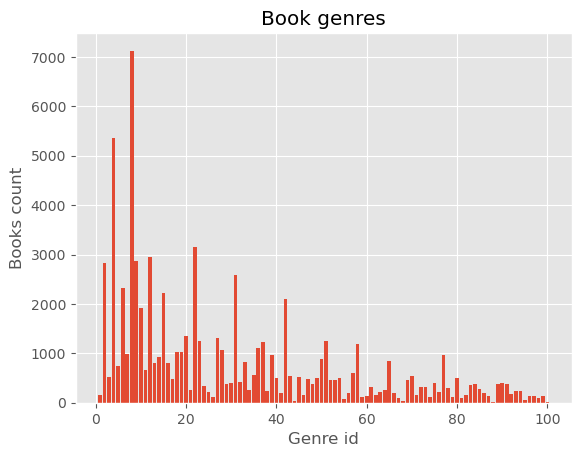

In [ ]:
plt.style.use('ggplot')
plt.bar(x=np.arange(len(genres_count)) + 1, height = genres_count.values())
plt.title('Book genres')
plt.xlabel('Genre id')
plt.ylabel('Books count')

# Pre-processing

In [21]:
### Preprocessing functions
def stemming(x):
    ps = PorterStemmer() # Initialize Python porter stemmer
    return [ps.stem(w) for w in x]

def lemmatization(x):
    wnl = WordNetLemmatizer() # Initialize wordnet lemmatizer
    return [wnl.lemmatize(w) for w in x]

def stop_words(x):
    stop_words = set(stopwords.words('english'))
    return [w for w in x if not w.lower() in stop_words]

In [22]:
def preprocessing(X, rm_stop, stem, lem):
    X_new=[]
    for doc in tqdm(X):
        new_doc=word_tokenize(doc.lower().translate(str.maketrans("", "", string.punctuation)))
        if rm_stop:
            new_doc=stop_words(new_doc)
        if stem:
            new_doc=stemming(new_doc)
        if lem:
            new_doc=lemmatization(new_doc)
        X_new.append(new_doc)    
    return X_new

In [31]:
mlb = MultiLabelBinarizer()
df=books_df.loc[:1000, :]
X,y=df.text.tolist(), pd.DataFrame(mlb.fit_transform(df.idx_genres),columns=mlb.classes_, index=df.index)

In [32]:
X_new=preprocessing(X, True, True, False)

100%|██████████| 1001/1001 [20:00<00:00,  1.20s/it]


# Exportation

In [33]:
with open("./data/dict_genres.json", "w") as outfile: 
    json.dump(genres_dict, outfile) #will be useful to remap genres names to the ids later

In [34]:
#Exporting the X and y
with open('./data/X.pkl', 'wb') as f:
    pickle.dump(X_new, f)

with open('./data/y.pkl', 'wb') as f:
    pickle.dump(y, f)